In [1]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
import random
import tensorflow as tf
import numpy as np
import xarray as xr
import rioxarray as rxr
import gcsfs

2023-04-21 17:06:10.803850: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Copy csvs from GCP bucket with list of train, test, and validation data files
fs = gcsfs.GCSFileSystem(project='sen1floods11')
fs.ls('sen1floods11/v1.1/splits/flood_handlabeled')

['sen1floods11/v1.1/splits/flood_handlabeled/flood_bolivia_data.csv',
 'sen1floods11/v1.1/splits/flood_handlabeled/flood_test_data.csv',
 'sen1floods11/v1.1/splits/flood_handlabeled/flood_train_data.csv',
 'sen1floods11/v1.1/splits/flood_handlabeled/flood_valid_data.csv']

In [3]:
# Create model checkpoint folder
if not os.path.isdir('checkpoints'):
    os.mkdir('checkpoints')

In [4]:
# Examine the S2 bucket
fs.ls('sen1floods11/v1.1/data/flood_events/HandLabeled/S2Hand')[:5]

['sen1floods11/v1.1/data/flood_events/HandLabeled/S2Hand/Bolivia_103757_S2Hand.tif',
 'sen1floods11/v1.1/data/flood_events/HandLabeled/S2Hand/Bolivia_129334_S2Hand.tif',
 'sen1floods11/v1.1/data/flood_events/HandLabeled/S2Hand/Bolivia_195474_S2Hand.tif',
 'sen1floods11/v1.1/data/flood_events/HandLabeled/S2Hand/Bolivia_23014_S2Hand.tif',
 'sen1floods11/v1.1/data/flood_events/HandLabeled/S2Hand/Bolivia_233925_S2Hand.tif']

In [5]:
s2_hand_files = fs.ls('sen1floods11/v1.1/data/flood_events/HandLabeled/S2Hand')
len(s2_hand_files)

446

In [6]:
label_files = fs.ls('sen1floods11/v1.1/data/flood_events/HandLabeled/LabelHand')
len(label_files)

446

In [7]:
s2_hand_files[:5]

['sen1floods11/v1.1/data/flood_events/HandLabeled/S2Hand/Bolivia_103757_S2Hand.tif',
 'sen1floods11/v1.1/data/flood_events/HandLabeled/S2Hand/Bolivia_129334_S2Hand.tif',
 'sen1floods11/v1.1/data/flood_events/HandLabeled/S2Hand/Bolivia_195474_S2Hand.tif',
 'sen1floods11/v1.1/data/flood_events/HandLabeled/S2Hand/Bolivia_23014_S2Hand.tif',
 'sen1floods11/v1.1/data/flood_events/HandLabeled/S2Hand/Bolivia_233925_S2Hand.tif']

In [8]:
label_files[:5]

['sen1floods11/v1.1/data/flood_events/HandLabeled/LabelHand/Bolivia_103757_LabelHand.tif',
 'sen1floods11/v1.1/data/flood_events/HandLabeled/LabelHand/Bolivia_129334_LabelHand.tif',
 'sen1floods11/v1.1/data/flood_events/HandLabeled/LabelHand/Bolivia_195474_LabelHand.tif',
 'sen1floods11/v1.1/data/flood_events/HandLabeled/LabelHand/Bolivia_23014_LabelHand.tif',
 'sen1floods11/v1.1/data/flood_events/HandLabeled/LabelHand/Bolivia_233925_LabelHand.tif']

In [9]:
# Download data
if not os.path.isdir('files'):
  os.makedirs('files/S2')
  os.makedirs('files/Labels')

  # See https://github.com/cloudtostreet/Sen1Floods11/tree/master/docs for definitions:
  # "S1Hand/: 446 Sentinel-1 GRD Chips overlapping labeled data."
  # "LabelHand/: 446 labeled chips of Water/NoWater/NoData."
  # "S2Hand/: 446 Sentinel-2 L1C Chips overlapping labeled data."
  fs.get(rpath='sen1floods11/v1.1/data/flood_events/HandLabeled/S2Hand/', lpath='./files/S2', recursive=True)
  fs.get(rpath='sen1floods11/v1.1/data/flood_events/HandLabeled/LabelHand/', lpath='./files/Labels', recursive=True)

In [10]:
# Create dataset for splitting into train, validation, and test datasets
file_df = pd.DataFrame({'X': s2_hand_files, 'y': label_files})

In [11]:
# Extract unique component of file names to check to make sure X and y files are correctly matched up
file_df['X_file'] = file_df['X'].apply(lambda x: re.sub('^.*S2Hand\/', '', x))
file_df['y_file'] = file_df['y'].apply(lambda x: re.sub('^.*LabelHand\/', '', x))
file_df['X_substr'] = file_df['X'].apply(lambda x: re.sub('(^.*S2Hand\/)|(_S2Hand\.tif$)', '', x))
file_df['y_substr'] = file_df['y'].apply(lambda x: re.sub('(^.*LabelHand\/)|(_LabelHand\.tif$)', '', x))
all_matching = all(file_df['X_substr'] == file_df['y_substr'])
print("All X files match all y files:", all_matching)

All X files match all y files: True


In [12]:
file_df.head()

,X,y,X_file,y_file,X_substr,y_substr
0,sen1floods11/v1.1/data/flood_events/HandLabele...,sen1floods11/v1.1/data/flood_events/HandLabele...,Bolivia_103757_S2Hand.tif,Bolivia_103757_LabelHand.tif,Bolivia_103757,Bolivia_103757
1,sen1floods11/v1.1/data/flood_events/HandLabele...,sen1floods11/v1.1/data/flood_events/HandLabele...,Bolivia_129334_S2Hand.tif,Bolivia_129334_LabelHand.tif,Bolivia_129334,Bolivia_129334
2,sen1floods11/v1.1/data/flood_events/HandLabele...,sen1floods11/v1.1/data/flood_events/HandLabele...,Bolivia_195474_S2Hand.tif,Bolivia_195474_LabelHand.tif,Bolivia_195474,Bolivia_195474
3,sen1floods11/v1.1/data/flood_events/HandLabele...,sen1floods11/v1.1/data/flood_events/HandLabele...,Bolivia_23014_S2Hand.tif,Bolivia_23014_LabelHand.tif,Bolivia_23014,Bolivia_23014
4,sen1floods11/v1.1/data/flood_events/HandLabele...,sen1floods11/v1.1/data/flood_events/HandLabele...,Bolivia_233925_S2Hand.tif,Bolivia_233925_LabelHand.tif,Bolivia_233925,Bolivia_233925


In [13]:
# Split into train, test, and validation datasets
# Original script uses 35% test data, 35% validation data, and 30%
# Set random seed for reproducible results
np.random.seed(42)
# Make a copy of the df index
file_idx = np.array(file_df.index.array.copy())
np.random.shuffle(file_idx)
train_end_idx = int(len(file_idx) * 0.3)
validation_end_idx = train_end_idx + int(len(file_idx) * 0.35)
test_end_idx = validation_end_idx + int(len(file_idx) * 0.35)
train_subset = file_idx[:train_end_idx]
validation_subset = file_idx[train_end_idx:validation_end_idx]
test_subset = file_idx[validation_end_idx:]

# Extract file names from original df
X_train, y_train = file_df['X_file'].iloc[train_subset], file_df['y_file'].iloc[train_subset]
X_validation, y_validation = file_df['X_file'].iloc[validation_subset], file_df['y_file'].iloc[validation_subset]
X_test, y_test = file_df['X_file'].iloc[test_subset], file_df['y_file'].iloc[test_subset]
print('Training data shapes:', X_train.shape, y_train.shape)
print('Validation data shapes:', X_validation.shape, y_validation.shape)
print('Test data shapes:', X_test.shape, y_test.shape)

Training data shapes: (133,) (133,)
Validation data shapes: (156,) (156,)
Test data shapes: (157,) (157,)


In [14]:
# Define model hyperparameters
LR = 5e-4
EPOCHS = 100
EPOCHS_PER_UPDATE = 1
RUNNAME = "Sen1Floods11"

In [15]:
# From https://openaccess.thecvf.com/content_CVPRW_2020/papers/w11/Bonafilia_Sen1Floods11_A_Georeferenced_Dataset_to_Train_and_Test_Deep_Learning_CVPRW_2020_paper.pdf
#"Reference Sentinel-2 flood maps
#were created after calculating Normalized Difference Vegetation Index (NDVI=(B8-B4)/(B8+B4), B=band) and Modified Normalized Difference Water Index (MNDWI= (B12-
#B3)/(B12+B3), B=band) bands, and applying an expert defined threshold of 0.2 and 0.3 respectively [57, 16]. Clouds
#were identified using a blue band reflectance threshold of
#less than 0.2. Cloud shadows were removed by projecting
#the shadows based on potential cloud heights, the solar azimuth angle, and solar zenith angle [15]. Cloud shadows
#have similar spectral signatures as floods, and thus are crucial to mask for accurate optical flood mapping."

# Approach:
# Calculate NDVI and MNDWI for each image, and then feed those into the CNN as inputs (with data augmentation etc...)


In [16]:
# Examine one training file to see DN stats
X_ex = rxr.open_rasterio("./files/S2/Bolivia_103757_S2Hand.tif")
print("min:", X_ex.min(), "mean:", X_ex.mean(), "max:", X_ex.max())
print("Shape:", X_ex.shape)

min: <xarray.DataArray ()>
array(0, dtype=int16)
Coordinates:
    spatial_ref  int64 0 mean: <xarray.DataArray ()>
array(332.20311268)
Coordinates:
    spatial_ref  int64 0 max: <xarray.DataArray ()>
array(5662, dtype=int16)
Coordinates:
    spatial_ref  int64 0
Shape: (13, 512, 512)


In [17]:
X_ex

<xarray.DataArray (band: 13, y: 512, x: 512)>
array([[[   0,    0, ..., 1356, 1356],
        [   0,    0, ..., 1356, 1356],
        ...,
        [   0,    0, ..., 1213, 1213],
        [   0,    0, ..., 1183, 1183]],

       [[   0,    0, ...,  922, 1036],
        [   0,    0, ...,  947, 1143],
        ...,
        [   0,    0, ...,  897,  877],
        [   0,    0, ...,  867,  874]],

       ...,

       [[   0,    0, ...,  674,  674],
        [   0,    0, ...,  674,  674],
        ...,
        [   0,    0, ...,  729,  500],
        [   0,    0, ...,  452,  295]],

       [[   0,    0, ...,  491,  491],
        [   0,    0, ...,  491,  491],
        ...,
        [   0,    0, ...,  280,  201],
        [   0,    0, ...,  189,  116]]], dtype=int16)
Coordinates:
  * band         (band) int64 1 2 3 4 5 6 7 8 9 10 11 12 13
  * x            (x) float64 -65.27 -65.26 -65.26 ... -65.22 -65.22 -65.22
  * y            (y) float64 -14.21 -14.21 -14.21 ... -14.26 -14.26 -14.26
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:       Area
    OVR_RESAMPLING_ALG:  NEAREST
    _FillValue:          0
    scale_factor:        1.0
    add_offset:          0.0
    long_name:           ('B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8...

In [18]:
# Examine one label file to see DN stats
y_ex = rxr.open_rasterio("./files/Labels/Bolivia_103757_LabelHand.tif")
print("Unique values:", np.unique(y_ex))

Unique values: [-1  0  1]


In [19]:
# Sample preprocessing calculation
# NDVI=(B8-B4)/(B8+B4)
# MNDWI= (B12-B3)/(B12+B3)
# Calculate indexes
ndvi = ((X_ex.sel(band=8) - X_ex.sel(band=4)) / (X_ex.sel(band=8) + X_ex.sel(band=4)))
mndwi = ((X_ex.sel(band=12) - X_ex.sel(band=3)) / (X_ex.sel(band=12) + X_ex.sel(band=3)))
# Fill values with invalid division
ndvi =  xr.where(np.isnan(ndvi), 0, ndvi)
mndwi =  xr.where(np.isnan(mndwi), 0, mndwi)
# Set data names
ndvi.name = "ndvi"
mndwi.name = "mndwi"

print("min:", ndvi.min(), "mean:", ndvi.mean(), "max:", ndvi.max())
print("\nmin:", mndwi.min(), "mean:", mndwi.mean(), "max:", mndwi.max())

min: <xarray.DataArray 'ndvi' ()>
array(-0.371484)
Coordinates:
    spatial_ref  int64 0 mean: <xarray.DataArray 'ndvi' ()>
array(0.11883897)
Coordinates:
    spatial_ref  int64 0 max: <xarray.DataArray 'ndvi' ()>
array(1.)
Coordinates:
    spatial_ref  int64 0

min: <xarray.DataArray 'mndwi' ()>
array(-1.)
Coordinates:
    spatial_ref  int64 0 mean: <xarray.DataArray 'mndwi' ()>
array(-0.06853597)
Coordinates:
    spatial_ref  int64 0 max: <xarray.DataArray 'mndwi' ()>
array(0.44816458)
Coordinates:
    spatial_ref  int64 0


In [32]:
# Concatenate the datasets in the band dimension
c = xr.concat([ndvi, mndwi], dim="band")
# Name the data array
c.name = "veg_water_calcs"
# Update coordinates and indexes
c.coords["band"] = pd.Index([0,1])
#c.sel(band=0)
c

<xarray.DataArray 'veg_water_calcs' (band: 2, y: 512, x: 512)>
array([[[ 0.        ,  0.        ,  0.        , ..., -0.16509434,
         -0.21962617, -0.15636918],
        [ 0.        ,  0.        ,  0.        , ..., -0.16724337,
         -0.21285141, -0.12056738],
        [ 0.        ,  0.        ,  0.        , ..., -0.20042644,
         -0.1287478 , -0.05591678],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  0.53050268,
          0.40410474,  0.41858736],
        [ 0.        ,  0.        ,  0.        , ...,  0.45502298,
          0.43434343,  0.44578313],
        [ 0.        ,  0.        ,  0.        , ...,  0.30325815,
          0.28822496,  0.42379958]],

       [[ 0.        ,  0.        ,  0.        , ..., -0.48775056,
          0.00074239, -0.10550763],
        [ 0.        ,  0.        ,  0.        , ..., -0.49283352,
         -0.03438395, -0.17804878],
        [ 0.        ,  0.        ,  0.        , ..., -0.49098621,
         -0.20644666, -0.30135135],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  0.00413223,
          0.06501096, -0.11971831],
        [ 0.        ,  0.        ,  0.        , ...,  0.0557567 ,
          0.05346821, -0.14965986],
        [ 0.        ,  0.        ,  0.        , ..., -0.14068441,
         -0.11976631, -0.38413361]]])
Coordinates:
  * x            (x) float64 -65.27 -65.26 -65.26 ... -65.22 -65.22 -65.22
  * y            (y) float64 -14.21 -14.21 -14.21 ... -14.26 -14.26 -14.26
    spatial_ref  int64 0
  * band         (band) int64 0 1

In [ ]:
def calc_veg_water_idx(input_arr: xr.DataArray) -> xr.DataArray:
    ndvi = ((input_arr.sel(band=8) - input_arr.sel(band=4)) / (input_arr.sel(band=8) + input_arr.sel(band=4)))
    mndwi = ((input_arr.sel(band=12) - input_arr.sel(band=3)) / (input_arr.sel(band=12) + input_arr.sel(band=3)))

In [35]:
#norm = transforms.Normalize([0.6851, 0.5235], [0.0820, 0.1102])
ch1_mean, ch2_mean = 0.6851, 0.5235
ch1_stddev, ch2_stdddev = 0.0820, 0.1102
# Note -> need to calculate new norm values for each band... Also only look at a couple bands?
#tf.keras.layers.Normalization(axis=None, mean=X_mean, variance=)

In [52]:
# Define functions to process train and test data

  
def processAndAugment(data: list) -> tuple[torch.Tensor, torch.Tensor]:
  '''
  Convert images to PIL format, randomly crop images,
  randomly apply horizontal and vertical flips,
  convert PIL to tensors and apply normalization
  '''
  (x, y) = data
  im, label = x.copy(), y.copy()

  # Convert to PIL for easier transforms
  im1 = Image.fromarray(im[0])
  im2 = Image.fromarray(im[1])
  label = Image.fromarray(label.squeeze())

  # Get params for random transforms
  i, j, h, w = transforms.RandomCrop.get_params(im1, (256, 256))

  # Crop image at random location
  im1 = F.crop(im1, i, j, h, w)
  im2 = F.crop(im2, i, j, h, w)
  label = F.crop(label, i, j, h, w)
  # Randomly apply horizontal flip
  if random.random() > 0.5:
    im1 = F.hflip(im1)
    im2 = F.hflip(im2)
    label = F.hflip(label)
  # Randomly apply vertical flip
  if random.random() > 0.5:
    im1 = F.vflip(im1)
    im2 = F.vflip(im2)
    label = F.vflip(label)
  
  # Normalize the image
  # Note: Normalize parameters are sequences of means and std, not sure
  # where these numbers come from
  norm = transforms.Normalize([0.6851, 0.5235], [0.0820, 0.1102])
  # Create stack of tensors
  im = torch.stack([transforms.ToTensor()(im1).squeeze(), transforms.ToTensor()(im2).squeeze()])
  im = norm(im)
  label = transforms.ToTensor()(label).squeeze()
  # Additional step to multiply everything by scalar
  # if (at least one cell?) has a data value between 0.003 and 0.004?
  if torch.sum(label.gt(0.003) * label.lt(0.004)):
    label *= 255
  label = label.round()

  return im, label



def processTestIm(data: list) -> tuple[torch.Tensor, torch.Tensor]:
  '''
  Convert images to PIL format, crop images,
  convert PIL to tensors and apply normalization
  '''
  (x, y) = data
  im, label = x.copy(), y.copy()
  norm = transforms.Normalize([0.6851, 0.5235], [0.0820, 0.1102])

  # convert to PIL for easier transforms
  im_c1 = Image.fromarray(im[0]).resize((512, 512))
  im_c2 = Image.fromarray(im[1]).resize((512, 512))
  label = Image.fromarray(label.squeeze()).resize((512, 512))

  # Create lists of cropped images for various dimensions
  im_c1s = [F.crop(im_c1, 0, 0, 256, 256), F.crop(im_c1, 0, 256, 256, 256),
            F.crop(im_c1, 256, 0, 256, 256), F.crop(im_c1, 256, 256, 256, 256)]
  im_c2s = [F.crop(im_c2, 0, 0, 256, 256), F.crop(im_c2, 0, 256, 256, 256),
          F.crop(im_c2, 256, 0, 256, 256), F.crop(im_c2, 256, 256, 256, 256)]
  labels = [F.crop(label, 0, 0, 256, 256), F.crop(label, 0, 256, 256, 256),
        F.crop(label, 256, 0, 256, 256), F.crop(label, 256, 256, 256, 256)]
  
  # Create stack of squeezed data converted from PIL to tensor for x and y
  ims = [torch.stack((transforms.ToTensor()(x).squeeze(),
                      transforms.ToTensor()(y).squeeze()))
                      for (x, y) in zip(im_c1s, im_c2s)]
  
  # Apply normalization
  ims = [norm(im) for im in ims]
  # Create stack from normalized tensors
  ims = torch.stack(ims)

  # Create list (and then stack) of tensors from label data
  labels = [(transforms.ToTensor()(label).squeeze()) for label in labels]
  labels = torch.stack(labels)

  if torch.sum(labels.gt(0.003) * labels.lt(0.004)):
    labels *= 255
  labels = labels.round()

  return ims, labels


In [53]:
# Load flood water train test and validation data from splits (From csv)
def getArrFlood(fname):
  return rasterio.open(fname).read()

def download_flood_water_data_from_list(l: list) -> list[tuple[np.ndarray, np.ndarray]]:
  '''
  Download flood water data, clip values and normalize
  '''
  i = 0
  tot_nan = 0
  tot_good = 0
  flood_data = []
  # Download flood data for x and y datasets
  for (im_fname, mask_fname) in l:
    if not os.path.exists(os.path.join("files/", im_fname)):
      print("test")
      continue
    arr_x = np.nan_to_num(getArrFlood(os.path.join("files/", im_fname)))
    arr_y = getArrFlood(os.path.join("files/", mask_fname))
    arr_y[arr_y == -1] = 255

    # Remove values outside specified range
    arr_x = np.clip(arr_x, -50, 1)
    # Normalize values between 0 and 1
    arr_x = (arr_x + 50) / 51

    if i % 100 == 0:
      print(im_fname, mask_fname)
    i += 1
    # Append the normalized data to the list as tuples of (x, y)
    flood_data.append((arr_x, arr_y))

  return flood_data

def load_flood_train_data(input_root: str, label_root: str) -> list[tuple[np.ndarray, np.ndarray]]:
  '''
  Load training data
  '''
    
  # Get file names
  training_files = list(zip(input_root + X_train, label_root + y_train))

  # Download data for each parsed dataset name
  return download_flood_water_data_from_list(training_files)

def load_flood_valid_data(input_root: str, label_root: str) -> list[tuple[np.ndarray, np.ndarray]]:
  '''
  Load validation data
  '''
  # Get file names
  validation_files = list(zip(input_root + X_validation, label_root + y_validation))

  # Download data for each parsed dataset name
  return download_flood_water_data_from_list(validation_files)

def load_flood_test_data(input_root: str, label_root: str) -> list[tuple[np.ndarray, np.ndarray]]:
  '''
  Load test data
  '''
  test_files = list(zip(input_root + X_test, label_root + y_test))

  # Download data for each parsed dataset name
  return download_flood_water_data_from_list(testing_files)

In [54]:
# Load training and validation data
train_data = load_flood_train_data('S2/', 'Labels/')
# Convert training dataset to class instance for working with pytorch
train_dataset = InMemoryDataset(train_data, processAndAugment)
# Create iterable for loading shuffled data in batches
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=16,
                                           shuffle=True,
                                           sampler=None,
                                           batch_sampler=None,
                                           num_workers=0,
                                           collate_fn=None,
                                           pin_memory=True,
                                           drop_last=False,
                                           timeout=0,
                                           worker_init_fn=None)
train_iter = iter(train_loader)

def custom_collate_fn(x: torch.utils.data.Dataset)\
  -> tuple[torch.Tensor, torch.Tensor]:
  '''
  Reshape data by extracting first element of each input data element
  into a list and converting to tensor, followed by the same for the second
  element of each input data element
  
  '''
  return (torch.cat([a[0] for a in x], 0), torch.cat([a[1] for a in x], 0))

# Load validatioon data
valid_data = load_flood_valid_data('S2/', 'Labels/')
# Convert to pytorch Dataset class instance
valid_dataset = InMemoryDataset(valid_data, processTestIm)
# Create iterable for loading shuffled data in batches with
# custom collate function
valid_loader = torch.utils.data.DataLoader(valid_dataset, 
                                           batch_size=4, 
                                           shuffle=True,
                                           sampler=None,
                                           batch_sampler=None,
                                           num_workers=0,
                                           collate_fn=custom_collate_fn,
                                           pin_memory=True,
                                           drop_last=False,
                                           timeout=0,
                                           worker_init_fn=None)

valid_iter = iter(valid_loader)

S2/Somalia_195014_S2Hand.tif Labels/Somalia_195014_LabelHand.tif
S2/India_399883_S2Hand.tif Labels/India_399883_LabelHand.tif
S2/USA_366607_S2Hand.tif Labels/USA_366607_LabelHand.tif
S2/Ghana_97516_S2Hand.tif Labels/Ghana_97516_LabelHand.tif


In [55]:
# Define the network using ResNet50
net = models.segmentation.fcn_resnet50(pretrained=False, num_classes=2, pretrained_backbone=False)
# 2 channels in the input image
# 64 channels produced by the convolution
# Use smaller kernel size if you think smaller features represent the key differences,
# use larger kernel size if you think there are larger features that need to be captured
# Lower stride would capture finer detail
net.backbone.conv1 = nn.Conv2d(2, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Make sure to enable GPU in `Notebook settings/Hardware accelerator`
criterion = nn.CrossEntropyLoss(weight=torch.tensor([1,8]).float().cuda(), ignore_index=255)
optimizer = torch.optim.Adam(net.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer=optimizer, 
    T_0=len(train_loader) * 10, # num iterations for first restart
    T_mult=2, # Factor to increase number of epochs between two warm restarts
    eta_min=0, # Min learning rate
    last_epoch=-1) # Index of last epoch


/Users/sashkawarner/miniconda3/envs/flood_api/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/sashkawarner/miniconda3/envs/flood_api/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/Users/sashkawarner/miniconda3/envs/flood_api/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and may be removed in the future, please use 'weights_backbone' instead.
  warnings.warn(
/Users/sashkawarner/miniconda3/envs/flood_api/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight 

AssertionError: Torch not compiled with CUDA enabled

In [20]:
def convertBNtoGN(module: models.segmentation.fcn.FCN, num_groups: int = 16) -> models.segmentation.fcn.FCN:
  '''
  Recursive function to apply group normalization
  Note: Group normalization is calculated independent of
  batch normalization and can have lower error compared to batch normalization
  '''
  # Note: Module == layer
  if isinstance(module, torch.nn.modules.batchnorm.BatchNorm2d):
    return nn.GroupNorm(num_groups, module.num_features,
                        eps=module.eps, affine=module.affine)
    
    if module.affine:
      mod.weight.data = module.weight.data.clone().detach()
      mod.bias.data = module.bias.data.clone().detach()

  for name, child in module.named_children():
    module.add_module(name, convertBNtoGN(child, num_groups=num_groups))
    
  return module
  
net = convertBNtoGN(net)

<IPython.core.display.Javascript object>

In [21]:
def computeIOU(output: torch.Tensor, target):
  output = torch.argmax(output, dim=1).flatten()
  target = target.flatten()

  no_ignore = target.ne(255).cuda()
  output = output.masked_select(no_ignore)
  target = target.masked_select(no_ignore)
  intersection = torch.sum(output * target)
  union = torch.sum(target) + torch.sum(output) - intersection
  iou = (intersection + .0000001) / (union + .0000001)

  if iou != iou:
    print("failed, replacing with 0")
    iou = torch.tensor(0).float()

  return iou

def computeAccuracy(output: torch.Tensor, target):
  output = torch.argmax(output, dim=1).flatten()
  target = target.flatten()
  no_ignore = target.ne(255).cuda()
  output = output.masked_select(no_ignore)
  target = target.masked_select(no_ignore)
  correct = torch.sum(output.eq(target))

  return correct.float() / len(target)
                               
def truePositives(output: torch.Tensor, target):
  output = torch.argmax(output, dim=1).flatten()
  target = target.flatten()
  no_ignore = target.ne(255).cuda()
  output = output.masked_select(no_ignore)
  target = target.masked_select(no_ignore)
  correct = torch.sum(output.eq(target))

  return correct.float() / len(target)

def trueNegatives(output: torch.Tensor, target):
  output = torch.argmax(output, dim=1).flatten()
  target = target.flatten()
  no_ignore = target.ne(255).cuda()
  output = output.masked_select(no_ignore)
  target = target.masked_select(no_ignore)
  output = (output == 0)
  target = (target == 0)
  correct = torch.sum(output * target)

  return correct

def falsePositive(output: torch.Tensor, target):
  output = torch.argmax(output, dim=1).flatten()
  target = target.flatten()
  no_ignore = target.ne(255).cuda()
  output = output.masked_select(no_ignore)
  target = target.masked_select(no_ignore)
  output = (output == 1)
  target = (target == 0)
  correct = torch.sum(output * target)

  return correct


def falseNegatives(output: torch.Tensor, target):
  output = torch.argmax(output, dim=1).flatten()
  target = target.flatten()
  no_ignore = target.ne(255).cuda()
  output = output.masked_select(no_ignore)
  target = target.masked_select(no_ignore)
  output = (output == 0)
  target = (target == 1)
  correct = torch.sum(output * target)

  return correct

<IPython.core.display.Javascript object>

In [22]:
# Training loop
training_losses = []
training_accuracies = []
training_ious = []

running_loss = 0
running_iou = 0
running_accuracy = 0
running_count = 0
max_valid_iou = 0

def train_loop(inputs, labels, net, optimizer, scheduler):
  global running_loss
  global running_iou
  global running_count
  global running_accuracy

  # zero the parameter gradients
  optimizer.zero_grad()
  net = net.cuda()

  # forward + backward + optimize
  outputs = net(inputs.cuda())
  loss = criterion(outputs["out"], labels.long().cuda())
  loss.backward()
  optimizer.step()
  scheduler.step()

  running_loss += loss
  running_iou += computeIOU(outputs["out"], labels.cuda())
  running_accuracy += computeAccuracy(outputs["out"], labels.cuda())
  running_count += 1

<IPython.core.display.Javascript object>

In [24]:
valid_losses = []
valid_accuracies = []
valid_ious = []

def validation_loop(validation_data_loader, net):
  global running_loss
  global running_iou
  global running_count
  global running_accuracy
  global max_valid_iou

  global training_losses
  global train_accuracies
  global training_ios
  global valid_losses
  global valid_accuracies
  global valid_ious

  # Loop through each X and y in the validation data loader
  # and sum loss, iou and accuracy
  net = net.eval()
  net = net.cuda()
  count = 0
  iou = 0
  loss = 0
  accuracy = 0
  with torch.no_grad():
    for (images, labels) in validation_data_loader:
      net = net.cuda()
      outputs = net(images.cuda())
      valid_loss = criterion(outputs["out"], labels.long().cuda())
      valid_iou = computeIOU(outputs["out"], labels.cuda())
      valid_accuracy = computeAccuracy(outputs["out"], labels.cuda())
      iou += valid_iou
      loss += valid_loss
      accuracy += valid_accuracy
      count += 1
    
  # Average IOU and accuracy
  iou = iou / count
  accuracy = accuracy / count

# Save check points for max IOU
  if iou > max_valid_iou:
    max_valid_iou = iou
    save_path = os.path.join("checkpoints", "{}_{}_{}.cp".format(RUNNAME, count, iou.item()))
    
    torch.save(net.state_dict(), save_path)
    print("model saved at", save_path)
  
  # Average loss
  loss = loss / count

  # Print metrics
  print("Training Loss:", running_loss / running_count)
  print("Training IOU:", running_iou / running_count)
  print("Training Accuracy:", running_accuracy / running_count)
  print("Validation Loss:", loss)
  print("Validation IOU:", iou)
  print("Validation Accuracy:", accuracy)

  training_losses.append(running_loss / running_count)
  training_accuracies.append(running_accuracy / running_count)
  training_ious.append(running_iou / running_count)
  valid_losses.append(loss)
  valid_accuracies.append(accuracy)
  valid_ious.append(iou)

<IPython.core.display.Javascript object>

In [25]:
# Define testing loop
def test_loop(test_data_loader, net):
  net = net.eval()
  net = net.cuda()
  count = 0
  iou = 0
  loss = 0
  accuracy = 0
  with torch.no_grad():
    for (images, labels) in tqdm(test_data_loader):
      net = net.cuda()
      outputs = net(images.cuda())
      valid_loss = criterion(outputs["out"], labels.long().cuda())
      valid_iou = computeIOU(outputs["out"], labels.cuda())
      valid_accuracy = computeAccuracy(outputs["out"], labels.cuda())
      #iou += valid_iou
      #loss += valid_loss
      accuracy += valid_accuracy
      count += 1
  iou = iou / count
  print("Test IOU:", iou)
  print("Test Accuracy:", accuracy / count)

<IPython.core.display.Javascript object>

In [26]:
# Training and validation scheme
running_loss = 0
running_iou = 0
running_count = 0
running_accuracy = 0

training_losses = []
training_accuracies = []
training_ious = []
valid_losses = []
valid_accuracies = []
valid_ious = []

def train_epoch(net, optimizer, scheduler, train_iter):
  for (inputs, labels) in tqdm(train_iter):
    train_loop(inputs.cuda(), labels.cuda(), net.cuda(), optimizer, scheduler)
  
def train_validation_loop(net, optimizer, scheduler, train_loader, valid_loader, num_epochs, cur_epoch):
  global running_loss
  global running_iou
  global running_count
  global running_accuracy
  
  net = net.train()
  running_loss = 0
  running_iou = 0
  running_count = 0
  running_accuracy = 0

  for i in tqdm(range(num_epochs)):
    train_iter = iter(train_loader)
    train_epoch(net, optimizer, scheduler, train_iter)

  clear_output()

  print("Current Epoch:", cur_epoch)
  validation_loop(iter(valid_loader), net)

<IPython.core.display.Javascript object>

Current Epoch: 40
Training Loss: tensor(0.6885, device='cuda:0', grad_fn=<DivBackward0>)
Training IOU: tensor(0.0172, device='cuda:0')
Training Accuracy: tensor(0.8779, device='cuda:0')
Validation Loss: tensor(0.6757, device='cuda:0')
Validation IOU: tensor(3.5396e-12, device='cuda:0')
Validation Accuracy: tensor(0.9116, device='cuda:0')


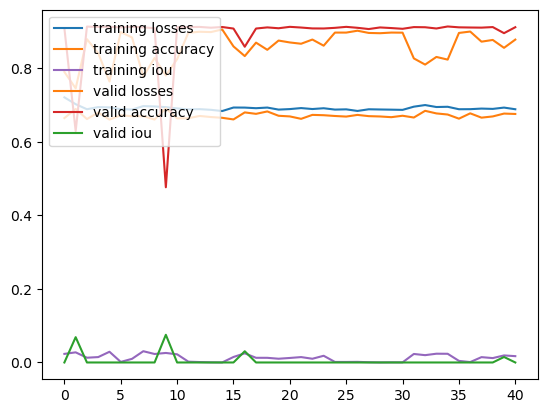

None

max valid iou: tensor(0.0753, device='cuda:0')


 33%|███▎      | 3/9 [00:02<00:05,  1.18it/s]

In [ ]:
# Train model and assess metrics
max_valid_iou = 0
start = 0
epochs = []
training_losses = []
training_accuracies = []
training_ious = []
valid_losses = []
valid_accuracies = []
valid_ious = []

for i in range(start, 1000):
  train_validation_loop(net, optimizer, scheduler, train_loader, valid_loader, 10, i)
  epochs.append(i)
  x = epochs
  plt.plot(x, [i.cpu().detach().numpy() for i in training_losses], label='training losses')
  plt.plot(x, [i.cpu().detach().numpy() for i in training_accuracies], 'tab:orange', label='training accuracy')
  plt.plot(x, [i.cpu().detach().numpy() for i in training_ious], 'tab:purple', label='training iou')
  plt.plot(x, [i.cpu().detach().numpy() for i in valid_losses], label='valid losses')
  plt.plot(x, [i.cpu().detach().numpy() for i in valid_accuracies], 'tab:red',label='valid accuracy')
  plt.plot(x, [i.cpu().detach().numpy() for i in valid_ious], 'tab:green',label='valid iou')
  plt.legend(loc="upper left")

  display(plt.show())
  print("max valid iou:", max_valid_iou)
